In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [71]:
from multi_scale_edge_detection.MultiScaleContourDetector import multi_scale_contour_detection_with_inhibition
from scipy.spatial import distance

In [80]:
# Path to the video file
video_path = 'boat.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# Initialize an empty list to store frames
frames = []

# Read the video frame by frame
while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Append the frame to the frames list
    frames.append(frame)

# Release the video capture object
cap.release()

# Convert the list of frames to a numpy array
frames_array = np.array(frames)

# Print the shape of the frames array
print("Shape of frames array:", frames_array.shape)

Shape of frames array: (300, 720, 1280, 3)


In [81]:
normalized_frames = []

# Iterate over each frame array
for frame in frames_array:
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Normalize the pixel values to range [0, 1]
    normalized_frame = gray_frame / 255.0
    
    # Append the normalized grayscale frame to the list
    normalized_frames.append(normalized_frame)

print("Normalization and storing completed.")

Normalization and storing completed.


In [ ]:
# Create an empty list to store the results
results_list = []

# Iterate over each normalized grayscale frame
for frame in normalized_frames:
    # Apply the function to the current frame and store the result
    result = multi_scale_contour_detection_with_inhibition(frame, N=8, sigma=1, alpha=0.00001)
    
    # Append the result to the results_list
    results_list.append(result)

print("Multi-scale contour detection completed for all frames.")

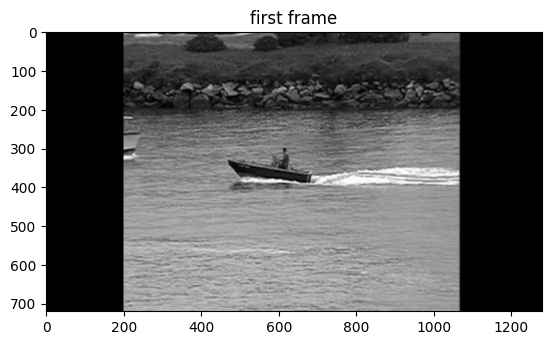

In [83]:
frame1 = normalized_frames[0]
plt.imshow(frame1 , cmap='gray')
plt.title('first frame')
plt.show()

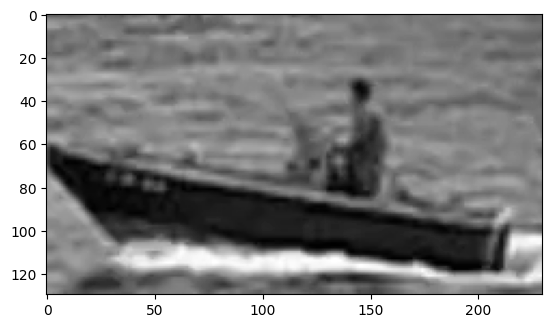

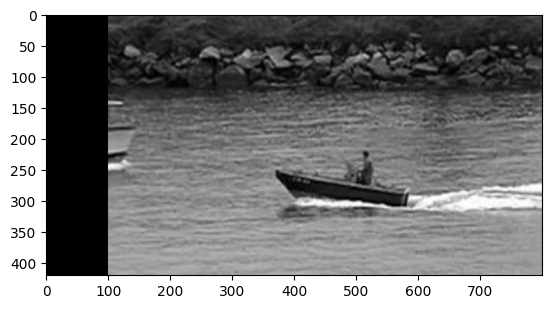

In [84]:
temp1 = frame1[270:400,470:700]
temp2 = frame1[80:500,100:900]
plt.figure(0)
plt.imshow(temp1, cmap="gray")
plt.figure(1)
plt.imshow(temp2, cmap="gray")

In [87]:
def get_hog_distance(image1, image2):

    # Read the images
    # img1 = cv2.imread(image1, cv2.IMREAD_UNCHANGED)
    # img2 = cv2.imread(image2, cv2.IMREAD_UNCHANGED)

    img1 = image1
    img2 = image2

    # Convert to float
    img1_float = img1.astype(float)
    img2_float = img2.astype(float)

    # define each block as 4x4 cells of 64x64 pixels each
    cell_size = (64, 64)        # h x w in pixels
    block_size = (4, 4)         # h x w in cells
    win_size = (8, 6)           # h x w in cells

    nbins = 9  # number of orientation bins
    image1_size = img1.shape[:2]  # h x w in pixels

    # create HOG objects
    hog1 = cv2.HOGDescriptor(
        _winSize=(win_size[1] * cell_size[1],
                win_size[0] * cell_size[0]),
        _blockSize=(block_size[1] * cell_size[1],
                    block_size[0] * cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    hog2 = cv2.HOGDescriptor(
        _winSize=(win_size[1] * cell_size[1],
                win_size[0] * cell_size[0]),
        _blockSize=(block_size[1] * cell_size[1],
                    block_size[0] * cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    n_cells = (image1_size[0] // cell_size[0], image1_size[1] // cell_size[1])

    # find features as a 1xN vector, then reshape into spatial hierarchy
    hog1_feats = hog1.compute(img1)
    hog1_feats = hog1_feats.reshape(
        n_cells[1] - win_size[1] + 1,
        n_cells[0] - win_size[0] + 1,
        win_size[1] - block_size[1] + 1,
        win_size[0] - block_size[0] + 1,
        block_size[1],
        block_size[0],
        nbins)
    
    hog2_feats = hog2.compute(img2)
    hog2_feats = hog2_feats.reshape(
        n_cells[1] - win_size[1] + 1,
        n_cells[0] - win_size[0] + 1,
        win_size[1] - block_size[1] + 1,
        win_size[0] - block_size[0] + 1,
        block_size[1],
        block_size[0],
        nbins)

    # Compute absolute difference between hog features
    diff = cv2.absdiff(hog1_feats,hog2_feats)

    # Compute similarity score
    similarity = np.sum(diff)
    return similarity

    

def template_matching(template, target):
    # Find template dimensions
    th, tw = template.shape[:2]

    # Compute the barycenter of the target image
    ty, tx = target.shape[:2]
    barycenter_x = tx // 2
    barycenter_y = ty // 2

    # Compute the size of the ROI
    roi_size_x = tw * 2
    roi_size_y = th * 2

    # Define the ROI boundaries
    roi_x = max(0, barycenter_x - roi_size_x // 2)
    roi_y = max(0, barycenter_y - roi_size_y // 2)
    roi_width = min(tx - roi_x, roi_size_x)
    roi_height = min(ty - roi_y, roi_size_y)

    # Slide template over the target image within the ROI and calculate similarity scores
    best_similarity = float('inf')
    best_location = None
    for y in range(roi_y, roi_y + roi_height - th):
        for x in range(roi_x, roi_x + roi_width - tw):
            roi = target[y:y+th, x:x+tw]
            similarity = get_hog_distance(template, roi)
            if similarity < best_similarity:
                best_similarity = similarity
                best_location = (x, y)

    return best_location

    

In [79]:
get_hog_distance('database/images/rino.pgm','database/images/rino_2.pgm')


193.09364

In [78]:
get_hog_distance('database/images/basket.pgm', 'database/images/rino.pgm')

211.3577

In [88]:
if __name__ == "__main__":
    # Load images
    template_img = frame1[270:400,470:700]
    target_img = normalized_frames[10]

    # Find the best location for template matching
    best_loc = template_matching(template_img, target_img)

    # Draw rectangle around the matched region
    tw, th = template_img.shape[:2]
    cv2.rectangle(target_img, best_loc, (best_loc[0] + tw, best_loc[1] + th), (0, 255, 0), 2)

    # Display result
    cv2.imshow('Template Matching', target_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\hog.cpp:244: error: (-215:Assertion failed) img.type() == CV_8U || img.type() == CV_8UC3 in function 'cv::HOGDescriptor::computeGradient'
